In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
dataset_path = "crime_district.csv"
df = pd.read_csv(dataset_path)
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   STATE/UT                              9841 non-null   object
 1   DISTRICT                              9841 non-null   object
 2   Year                                  9841 non-null   int64 
 3   Murder                                9841 non-null   int64 
 4   Assault on women                      9841 non-null   int64 
 5   Kidnapping and Abduction              9841 non-null   int64 
 6   Dacoity                               9841 non-null   int64 
 7   Robbery                               9841 non-null   int64 
 8   Arson                                 9841 non-null   int64 
 9   Hurt                                  9841 non-null   int64 
 10  Prevention of atrocities (POA) Act    9841 non-null   int64 
 11  Protection of Civil Rights (PC

In [3]:
def preprocess_data(df):
    # Handle missing values
    df.dropna(inplace=True)
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['STATE/UT', 'DISTRICT'], drop_first=True)
    
    return df

df = preprocess_data(df)

In [4]:
X = df.drop(columns=['Dacoity'])  
y = df['Dacoity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [7]:
if len(categorical_features) > 0:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
else:
    categorical_transformer = 'passthrough'

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
rf = RandomForestClassifier(max_features=5, n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])

pipeline.fit(X_train, y_train)
train_accuracy = pipeline.score(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Train Accuracy: 0.9996189024390244
Test Accuracy: 0.9558151345860844
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1882
           1       0.50      0.02      0.03        59
           2       0.33      0.07      0.11        15
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.50      0.50      0.50         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          16       1.00      1.00      1.00         1
          20       0.00      0.00      0.00         1

    accuracy                           0.96      1969
   macro avg       0.25      0.20      0.20      1969
weighted avg       0.94      0.96      0.

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [10]:
param_grid = {
    'classifier__max_features': np.arange(1, 6, 1),
    'classifier__n_estimators': np.arange(10, 210, 10)
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END classifier__max_features=1, classifier__n_estimators=10; total time=   0.1s
[CV] END classifier__max_features=1, classifier__n_estimators=20; total time=   0.2s
[CV] END classifier__max_features=1, classifier__n_estimators=30; total time=   0.2s
[CV] END classifier__max_features=1, classifier__n_estimators=40; total time=   0.4s
[CV] END classifier__max_features=1, classifier__n_estimators=40; total time=   0.4s
[CV] END classifier__max_features=1, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_features=1, classifier__n_estimators=60; total time=   0.5s
[CV] END classifier__max_features=1, classifier__n_estimators=70; total time=   0.7s
[CV] END classifier__max_features=1, classifier__n_estimators=80; total time=   0.6s
[CV] END classifier__max_features=1, classifier__n_estimators=90; total time=   0.7s
[CV] END classifier__max_features=1, classifier__n_estimators=90; total time=   0.8s
[CV] END classifier__max_features=1, classifier__n_estimators=100

In [11]:
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]), pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
grid_contour = grid_results.groupby(['classifier__max_features', 'classifier__n_estimators']).mean()
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_features', 'n_estimators', 'Accuracy']
grid_pivot = grid_reset.pivot(index='max_features', columns='n_estimators', values='Accuracy')



In [12]:
x = grid_pivot.columns.values
y = grid_pivot.index.values
z = grid_pivot.values

In [34]:
layout = go.Layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='n_estimators',
            font=dict(size=14, color='white')
        ),
        tickfont=dict(size=12, color='white')
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='max_features',
            font=dict(size=14, color='white')
        ),
        tickfont=dict(size=12, color='white')
    ),
    paper_bgcolor='#000000',
    plot_bgcolor='#000000',
    font=dict(color='white')
)
polynesian_blue_colorscale = [
    [0, '#002D72'],
    [0.5, '#4169E1'],
    [1, '#AFDBF5']
]

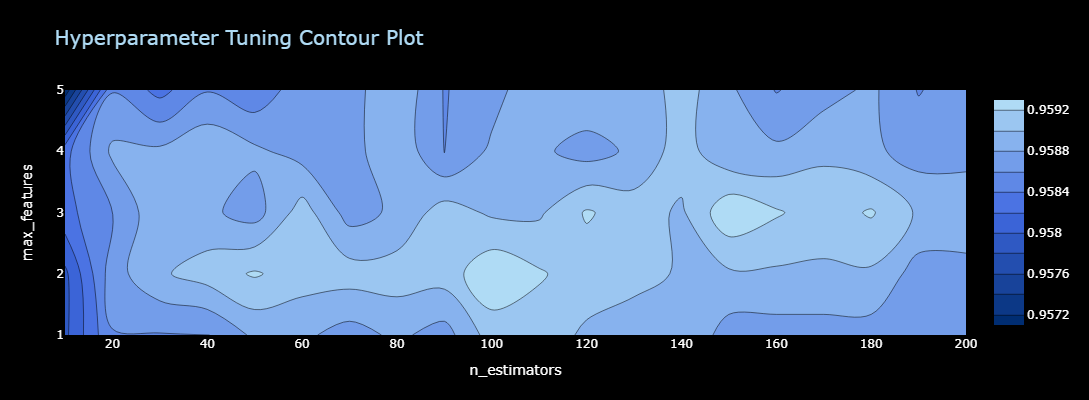

In [38]:
fig = go.Figure(data=[go.Contour(z=z, x=x, y=y, colorscale=polynesian_blue_colorscale)], layout=layout)
fig.update_layout(title='Hyperparameter Tuning Contour Plot', autosize=False, width=500, height=400, margin=dict(l=65, r=50, b=65, t=90),
                  title_font=dict(size=20, color='#AFDBF5'))
fig.show()


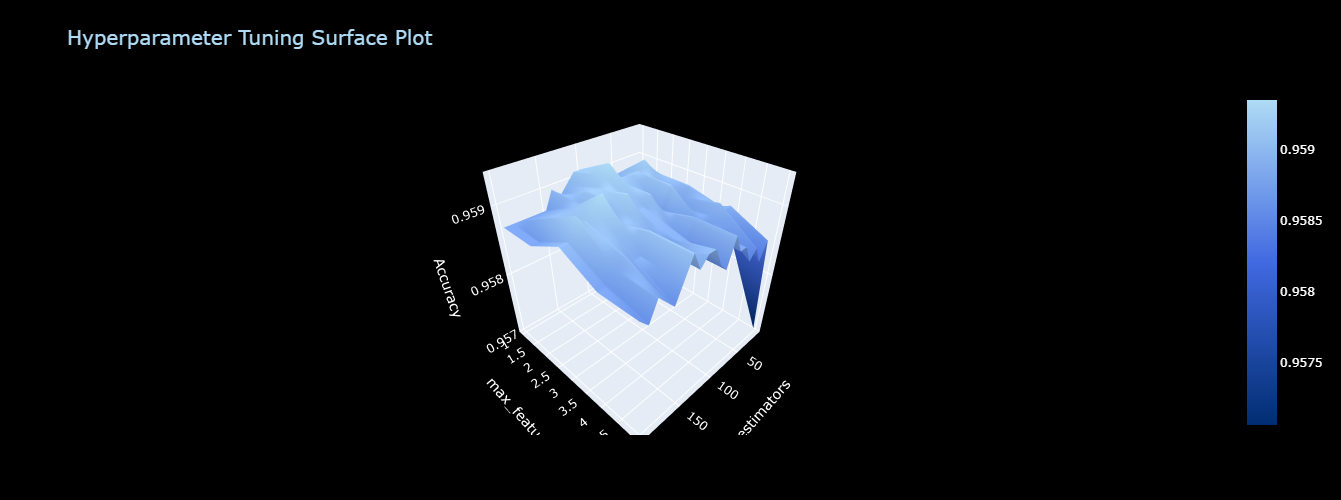

In [48]:
fig = go.Figure(data=[go.Surface(z=z, y=y, x=x, colorscale=polynesian_blue_colorscale)], layout=layout)
fig.update_layout(title='Hyperparameter Tuning Surface Plot', scene=dict(xaxis_title='n_estimators', yaxis_title='max_features', zaxis_title='Accuracy'),
                  autosize=False, width=600, height=500, margin=dict(l=65, r=50, b=65, t=90), title_font=dict(size=20, color='#AFDBF5'))
fig.show()